In [1]:
import os
import re
import math
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 스타일 설정
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# -----------------------
# [설정] 실행 파라미터
# -----------------------
class Config:
    LOG_DIR = "./logs/fgm"          # FGM 로그 파일 경로
    MIN_LAP_TIME = 20.0             # 첫 랩 완주로 인정할 최소 시간 (초)
    GOAL_RADIUS = 1.0               # 시작점으로 돌아왔다고 볼 거리 임계값 (m)
    # 분석할 맵 리스트 (사용자 환경에 맞게 수정 가능)
    MAPS = ["Opp_bumper_v_2", "Opp_bumper_slow_1", "Opp_bumper_slow_2"] 

config = Config()

# 로그 디렉토리 확인 및 생성
if not os.path.exists(config.LOG_DIR):
    print(f"알림: '{config.LOG_DIR}' 폴더가 없어 생성했습니다. 이 폴더에 csv 파일들을 넣어주세요.")
    os.makedirs(config.LOG_DIR, exist_ok=True)


In [2]:
# =========================================================
# 1) 파일명 파싱 (FGM 포맷 전용)
# =========================================================
# 예: Opp_bumper_v_2.csv_Gap1.3..._FGM_1764843339_GOAL_dur_10.95s.csv
FNAME_PATTERN = re.compile(
    r'(?P<map>.+)\.csv_Gap(?P<gap>[\d.]+)_Bub(?P<bub>[\d.]+)_Clr(?P<clr>[\d.]+)_WW(?P<ww>[\d.]+)_AW(?P<aw>[\d.]+)_SW(?P<sw>[\d.]+)_HB(?P<hb>[\d.]+)_CT(?P<ct>[\d.]+)_SA(?P<sa>[\d.]+)_DBS(?P<dbs>[\d.]+)_SPD(?P<spd>[\d.]+)_FGM_(?P<id>\d+)_(?P<result>[A-Z_]+)_dur_(?P<dur>[\d.]+)s\.csv'
)

def parse_filename(fname: str):
    m = FNAME_PATTERN.match(fname)
    if not m:
        return None
    d = m.groupdict()
    # 파라미터들을 실수형(float)으로 변환
    float_keys = ["gap", "bub", "clr", "ww", "aw", "sw", "hb", "ct", "sa", "dbs", "spd", "dur"]
    for k in float_keys:
        d[k] = float(d[k])
    # ID는 타임스탬프 역할을 하므로 정수형(int)
    d['id'] = int(d['id'])
    return d

# =========================================================
# 2) CSV 수치 데이터 추출
# =========================================================
def _is_float_str(s):
    try:
        float(s)
        return True
    except Exception:
        return False

def extract_numeric(df: pd.DataFrame) -> pd.DataFrame:
    # 't' 컬럼이 숫자인 행만 추출 (헤더나 메타데이터 행 제외)
    mask = df["t"].apply(
        lambda v: (isinstance(v, (int, float)) or (isinstance(v, str) and _is_float_str(v)))
    )
    num = df[mask].copy()
    if num.empty:
        return num

    for col in ["t", "x", "y"]:
        num[col] = num[col].astype(float)
    return num

# =========================================================
# 3) 첫 랩 완주 시간 계산
# =========================================================
def calc_first_lap_time(num_df: pd.DataFrame, min_lap_time: float = 10.0, goal_radius: float = 1.0):
    if num_df.empty:
        return None
    x0, y0 = num_df["x"].iloc[0], num_df["y"].iloc[0]
    for _, row in num_df.iterrows():
        t = row["t"]
        if t < min_lap_time:
            continue
        d = math.hypot(row["x"] - x0, row["y"] - y0)
        if d < goal_radius:
            return t
    return None

# =========================================================
# 4) 개별 로그 파일 분석 실행
# =========================================================
def analyze_run(path: str, min_lap_time: float = 20.0, goal_radius: float = 1.0) -> dict:
    fname = os.path.basename(path)
    meta = parse_filename(fname)
    if meta is None:
        raise ValueError(f"파일명 형식이 맞지 않습니다: {fname}")

    df = pd.read_csv(path)

    # 요약 정보 파싱
    finish_row = df.loc[df["t"] == "Finish Reason", "x"]
    finish_reason = finish_row.iloc[0] if not finish_row.empty else meta["result"]

    duration_row = df.loc[df["t"] == "Duration (s)", "x"]
    duration_summary = float(duration_row.iloc[0]) if not duration_row.empty else None

    # 수치 데이터 로드
    num = extract_numeric(df)
    duration_numeric = num["t"].iloc[-1] if not num.empty else 0.0

    info = {
        **meta,
        "finish_reason": finish_reason,
        "effective_time": None,
        "file_path": path
    }

    result = meta["result"]

    # 결과에 따른 유효 시간(Effective Time) 설정
    if result == "GOAL":
        if duration_summary is not None:
            info["effective_time"] = duration_summary
        else:
            info["effective_time"] = duration_numeric
    elif result == "ABORT":
        if not num.empty:
            lap_time = calc_first_lap_time(num, min_lap_time, goal_radius)
            if lap_time is not None:
                info["effective_time"] = lap_time
    
    return info

# =========================================================
# 5) 최신 로그 파일 선별 (중복 파라미터 제거)
# =========================================================
def get_latest_log_files(log_dir: str):
    all_files = glob.glob(os.path.join(log_dir, "*.csv"))
    
    # Key: (map, gap, bub, clr, ww, aw, sw, hb, ct, sa, dbs, spd)
    # Value: (id, filepath)
    latest_files_map = {}

    print(f"[{log_dir}] 폴더 검색 중...")
    
    for fpath in all_files:
        fname = os.path.basename(fpath)
        meta = parse_filename(fname)
        
        if meta is None:
            continue
            
        # 식별 키: 맵 + 11개 튜닝 파라미터
        key = (
            meta['map'], meta['gap'], meta['bub'], meta['clr'], meta['ww'], 
            meta['aw'], meta['sw'], meta['hb'], meta['ct'], meta['sa'], 
            meta['dbs'], meta['spd']
        )
        file_id = meta['id']
        
        # 더 최신 ID(Timestamp)가 있으면 교체
        if key not in latest_files_map:
            latest_files_map[key] = (file_id, fpath)
        else:
            existing_id, _ = latest_files_map[key]
            if file_id > existing_id:
                latest_files_map[key] = (file_id, fpath)
    
    selected_files = [val[1] for val in latest_files_map.values()]
    print(f"총 {len(all_files)}개 파일 중 최신 파일 {len(selected_files)}개를 선별했습니다.")
    
    return selected_files


In [3]:
# 메인 실행부
target_files = get_latest_log_files(config.LOG_DIR)

results_list = []
for fpath in target_files:
    try:
        run_info = analyze_run(fpath, min_lap_time=10.0, goal_radius=2.0)
        results_list.append(run_info)
    except Exception as e:
        print(f"Error processing {os.path.basename(fpath)}: {e}")

df_results = pd.DataFrame(results_list)

if not df_results.empty:
    print("\n==== 분석 완료 데이터 (상위 5개) ====")
    # 정렬 기준: 맵 -> 파라미터 순
    sort_cols = ['map', 'gap', 'bub', 'clr', 'ww', 'aw', 'sw', 'hb', 'ct', 'sa', 'dbs', 'spd']
    df_results = df_results.sort_values(by=sort_cols)
    
    # 주요 컬럼만 출력
    cols = ['map', 'result', 'effective_time'] + sort_cols
    display(df_results[cols].head())
    
    print(f"\n총 분석된 케이스 수: {len(df_results)}")
else:
    print("분석할 유효한 데이터가 없습니다. logs/fgm 폴더를 확인해주세요.")


[./logs/fgm] 폴더 검색 중...
총 16개 파일 중 최신 파일 16개를 선별했습니다.

==== 분석 완료 데이터 (상위 5개) ====


,map,result,effective_time,map,gap,bub,clr,ww,aw,sw,hb,ct,sa,dbs,spd
3,Opp_bumper_slow_0.5,GOAL,9.96,Opp_bumper_slow_0.5,1.2,0.50,0.55,0.6,6.0,0.08,2.0,0.25,0.5,0.12,4.0
15,Opp_bumper_slow_0.5,GOAL,10.95,Opp_bumper_slow_0.5,1.3,0.55,0.60,0.5,5.0,0.10,2.5,0.30,0.4,0.15,3.5
12,Opp_bumper_slow_1,CRASH,NaN,Opp_bumper_slow_1,1.2,0.50,0.55,0.6,6.0,0.08,2.0,0.25,0.5,0.12,4.0
4,Opp_bumper_slow_1,GOAL,11.87,Opp_bumper_slow_1,1.3,0.55,0.60,0.5,5.0,0.10,2.5,0.30,0.4,0.15,3.5
0,Opp_bumper_slow_1.5,ABORT,NaN,Opp_bumper_slow_1.5,1.2,0.50,0.55,0.6,6.0,0.08,2.0,0.25,0.5,0.12,4.0



총 분석된 케이스 수: 16


In [4]:
def find_best_weights_df(df, map_names):
    valid_df = df[df['effective_time'].notnull()]
    if valid_df.empty:
        return []

    # 11개 파라미터
    param_cols = ['gap', 'bub', 'clr', 'ww', 'aw', 'sw', 'hb', 'ct', 'sa', 'dbs', 'spd']
    
    # 파라미터 조합별로 각 맵의 최소 시간(effective_time)을 피벗 테이블로 정리
    grouped = valid_df.groupby(param_cols + ['map'])['effective_time'].min().unstack()
    
    # 지정된 모든 맵(map_names)에 기록이 있는지 확인
    for m in map_names:
        if m not in grouped.columns:
            grouped[m] = None
            
    # 모든 맵을 완주한(값이 있는) 조합만 필터링
    complete_records = grouped.dropna(subset=map_names).copy()
    
    if complete_records.empty:
        return []

    # Total Time (맵 기록 합산)
    complete_records['total_time'] = complete_records[map_names].sum(axis=1)
    complete_records = complete_records.sort_values('total_time')
    return complete_records

best_results = find_best_weights_df(df_results, config.MAPS)

print("\n==== [Top 10] 지정된 맵 합산 기록 기준 베스트 파라미터 ====")
if len(best_results) == 0:
    print("지정된 모든 맵을 완주한 파라미터 조합이 없습니다.")
else:
    display(best_results.head(10))



==== [Top 10] 지정된 맵 합산 기록 기준 베스트 파라미터 ====


,,,,,,,,,,map,Opp_bumper_slow_0.5,Opp_bumper_slow_1,Opp_bumper_slow_1.5,Opp_bumper_slow_2,Opp_bumper_v_2,Opp_bumper_v_3,Opp_bumper_v_4,Opp_bumper_v_5,total_time
gap,bub,clr,ww,aw,sw,hb,ct,sa,dbs,spd,,,,,,,,,
1.3,0.55,0.6,0.5,5.0,0.1,2.5,0.3,0.4,0.15,3.5,10.95,11.87,11.3,9.87,10.95,11.0,10.94,11.38,32.69


In [5]:
def find_rerun_candidates_df(df, map_names):
    param_cols = ['gap', 'bub', 'clr', 'ww', 'aw', 'sw', 'hb', 'ct', 'sa', 'dbs', 'spd']
    # 시도된 모든 파라미터 조합 추출
    params = df[param_cols].drop_duplicates()
    reruns = []
    
    for _, p in params.iterrows():
        # 해당 파라미터 조합에 대해...
        cond = True
        for col in param_cols:
            cond &= (df[col] == p[col])
            
        for m in map_names:
            # 특정 맵의 기록이 없는지 확인
            subset = df[cond & (df['map'] == m) & (df['effective_time'].notnull())]
            if subset.empty:
                rerun_info = {"missing_map": m}
                rerun_info.update(p.to_dict())
                reruns.append(rerun_info)
                
    return pd.DataFrame(reruns)

rerun_results = find_rerun_candidates_df(df_results, config.MAPS)

print("\n==== 재실험이 필요한 (누락된 맵, 파라미터) 목록 ====")
if rerun_results.empty:
    print("재실험이 필요한 조합이 없습니다.")
else:
    display(rerun_results)



==== 재실험이 필요한 (누락된 맵, 파라미터) 목록 ====


,missing_map,gap,bub,clr,ww,aw,sw,hb,ct,sa,dbs,spd
0,Opp_bumper_slow_1,1.2,0.5,0.55,0.6,6.0,0.08,2.0,0.25,0.5,0.12,4.0


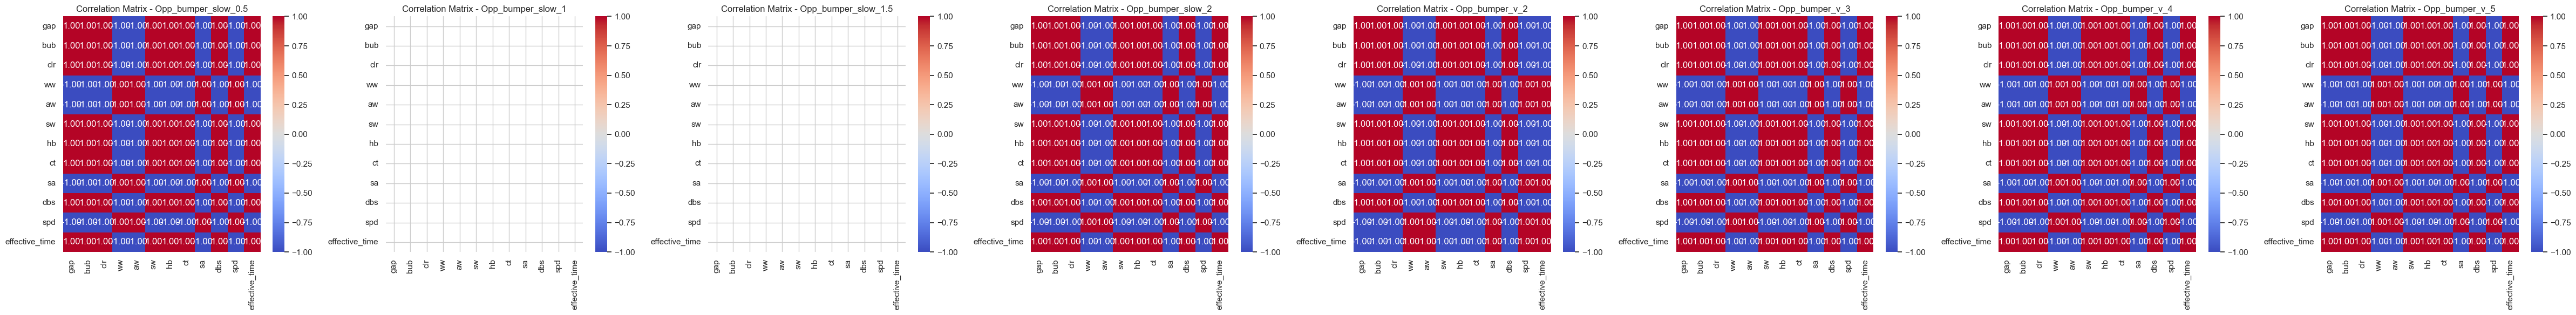

In [6]:
if not df_results.empty and df_results['effective_time'].notnull().sum() > 0:
    maps_in_data = df_results['map'].unique()

    # 맵 개수에 따라 그래프 크기 조절
    plt.figure(figsize=(6 * len(maps_in_data), 6))
    
    for i, map_name in enumerate(maps_in_data):
        plt.subplot(1, len(maps_in_data), i+1)
        
        target_df = df_results[(df_results['map'] == map_name) & (df_results['effective_time'].notnull())]
        
        if target_df.empty:
            plt.title(f"{map_name}: No Data")
            continue

        param_cols = ['gap', 'bub', 'clr', 'ww', 'aw', 'sw', 'hb', 'ct', 'sa', 'dbs', 'spd']
        corr_cols = param_cols + ['effective_time']
        
        # 상관관계 계산
        corr = target_df[corr_cols].corr()
        
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
        plt.title(f"Correlation Matrix - {map_name}")
        
    plt.tight_layout()
    plt.show()
else:
    print("상관관계를 분석할 데이터가 충분하지 않습니다.")
